In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


## dsets

In [2]:
torch.cuda.set_device(4)

In [ ]:
dls = get_seutao_dls(Meta.df_comb1, np_file, csv_file, bs=64)

## Load

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, n_classes=6, embed_size=2048, LSTM_UNITS=2048, DO = 0.3):
        super(NeuralNet, self).__init__()
        
#         self.embedding_dropout = SpatialDropout(0.0) #DO)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

        self.linear = nn.Linear(LSTM_UNITS*2, n_classes)

    def forward(self, x):
        h_embedding = x

        h_embadd = torch.cat((h_embedding[:,:,:2048], h_embedding[:,:,:2048]), -1)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
#         print([x.shape for x in [h_lstm1, h_lstm2, h_conc_linear1, h_conc_linear2, h_embadd]])
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2 + h_embadd

        output = self.linear(hidden)
        
        return output

In [5]:
def get_feat_dls_feat(df, np_file, csv_file, bs=1, num_workers=8):
    print('loading features')
    features = np.load(str(np_file))
    prob_df = pd.read_csv(csv_file)
    sops = [Path(f).stem for f in prob_df.filename.values]
    feature_map = dict(zip(sops, features))
    print('Done loading features')

    pad_to = None if bs == 1 else max_seq_len
    dsets = get_3d_dsets(df, open_fn=OpenFeats(feature_map), pad_to=pad_to)
    return get_dls(dsets, bs, [Cuda()], num_workers)


In [6]:
m = NeuralNet().cuda().half()

In [7]:
xb,yb = dls.one_batch()

In [8]:
m(xb).shape

torch.Size([64, 58, 6])

In [9]:
learn = get_learner(dls, m)

In [12]:
name = 'seutao_2nd_place_lstm'

In [10]:
learn.add_cb(DePadLoss(), SaveModelCallback(name))

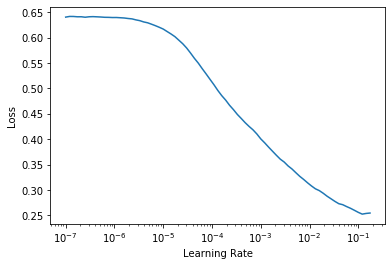

In [12]:
learn.lr_find()

## Train

In [13]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.064152,0.067834,0.977568,0.960583,00:39
1,0.066119,0.066495,0.977607,0.959292,00:39
2,0.064652,0.071668,0.977428,0.957682,00:39
3,0.062174,0.064463,0.978111,0.960701,00:39
4,0.061689,0.063230,0.978446,0.961352,00:39
5,0.059714,0.063128,0.978586,0.960725,00:39
6,0.057271,0.061909,0.978977,0.961660,00:39
7,0.056545,0.061385,0.979071,0.962181,00:39
8,0.055138,0.060900,0.979407,0.962442,00:39
9,0.053841,0.060642,0.979449,0.962453,00:39


NameError: name 'name' is not defined

## Submit

In [13]:
submit_predictions(m, f'runs/{name}-1', f'subm/{name}', 'testing seutao features 2nd place model')

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:02<00:00, 9.62MB/s]


In [14]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14065966,
 'totalBytes': 27277209,
 'date': '2020-01-07T03:23:54.607Z',
 'description': 'testing seutao features 2nd place model',
 'errorDescription': None,
 'fileName': 'seutao_2nd_place_lstm.csv',
 'publicScore': '0.81449',
 'privateScore': '0.04711',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14065966/14065966.raw'}